In [1]:
import tensorflow as tf
import numpy as np
import cv2 
import os
import glob
import tensorflow_addons as tfa
import math
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
pwd

'E:\\SNN_Based_Object_Counter'

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import pathlib
os.chdir(".")
data_dir=pathlib.Path("train")

# Loading Training & Testing tf.dataset

In [5]:
from tensorflow.keras import layers

batch_size = 32
img_height = 150
img_width = 150
data_dir=pathlib.Path(".\\train")

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  validation_split=0.3,
  subset='training',  
  batch_size=35,
  image_size=(img_height, img_width))
train_d=tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=122,
    validation_split=0.3,
    batch_size=35,
    subset="training",
    image_size=(img_height,img_width))



def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return img, label

def augment_using_ops(images, labels):
    images = tf.cast(images, tf.float32) / 255.
    images = tf.image.random_flip_left_right(images)
    images = tf.image.random_flip_up_down(images)
    images = tf.image.rot90(images)
    return images,labels



train_ds=train_ds.shuffle(3200,reshuffle_each_iteration=True)
train_ds = train_ds.map(augment_using_ops)


train_d=train_d.shuffle(3200,reshuffle_each_iteration=True)
train_d=train_d.map(_normalize_img)

train_fin=train_ds.concatenate(train_d)
train_fin=train_fin.unbatch().shuffle(6400,reshuffle_each_iteration=True).batch(30)

Found 4605 files belonging to 3 classes.
Using 3224 files for training.
Found 4605 files belonging to 3 classes.
Using 3224 files for training.


In [22]:
train_fin

<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)>

In [46]:


def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  validation_split=0.3,
  subset="validation",
  image_size=(img_height, img_width))
test_ds = test_ds.map(_normalize_img)
test_ds = test_ds.shuffle(1381)

Found 4605 files belonging to 3 classes.
Using 1381 files for validation.


In [47]:
test_ds

<ShuffleDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int32)>

# Building the LabelMap

In [8]:
label_map=sorted([i for i in os.listdir(".\\train") if "xgb" not in i])

In [9]:
label_map

['ep_black', 'ep_green', 'ep_orange']

# Building The SNN Model


In [6]:


base_resnet=tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(150,150,3),classes=5)
# for i in base_resnet.layers[:(math.ceil(len(base_resnet.layers)/2))]:
#     i.trainable=False
conv1=Conv2D(48,(1,1),padding="valid",activation="relu")
dr1=layers.Dropout(0.3)
avgpool1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))
conv2=Conv2D(78,(1,1),padding="same",activation="relu")
dr2=layers.Dropout(0.2)
flatten_layer = Flatten()
dense1 = Dense(108,activation="sigmoid")
dist=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
embedding_model=tf.keras.Sequential([base_resnet,conv1,dr1,avgpool1,conv2,dr2,flatten_layer,dense1,dist])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 48)          98352     
                                                                 
 dropout (Dropout)           (None, 5, 5, 48)          0         
                                                                 
 average_pooling2d (AverageP  (None, 2, 2, 48)         0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 78)          3822      
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 78)          0         
                                                        

In [80]:
embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='.\\tmp\\3cat_ckpt_{epoch:04d}_{loss:.5f}.hdf5',
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True)

history = embedding_model.fit(train_fin, epochs=400,callbacks=[model_checkpoint])

Epoch 1/400
215/215 [==============================] - 67s 261ms/step - loss: 0.2042
Epoch 2/400
215/215 [==============================] - 89s 259ms/step - loss: 0.1817
Epoch 3/400
215/215 [==============================] - 62s 259ms/step - loss: 0.1892
Epoch 4/400
215/215 [==============================] - 63s 259ms/step - loss: 0.1860
Epoch 5/400
215/215 [==============================] - 62s 260ms/step - loss: 0.2031
Epoch 6/400
215/215 [==============================] - 63s 260ms/step - loss: 0.1822
Epoch 7/400
215/215 [==============================] - 63s 260ms/step - loss: 0.1496
Epoch 8/400
215/215 [==============================] - 63s 260ms/step - loss: 0.1449
Epoch 9/400
215/215 [==============================] - 64s 262ms/step - loss: 0.1352
Epoch 10/400
215/215 [==============================] - 66s 262ms/step - loss: 0.1382
Epoch 11/400
215/215 [==============================] - 64s 262ms/step - loss: 0.1440
Epoch 12/400
215/215 [==============================] - 64s 263

215/215 [==============================] - 63s 258ms/step - loss: 0.0219
Epoch 191/400
215/215 [==============================] - 63s 259ms/step - loss: 0.0202
Epoch 192/400
215/215 [==============================] - 63s 259ms/step - loss: 0.0421
Epoch 193/400
215/215 [==============================] - 63s 258ms/step - loss: 0.0184
Epoch 194/400
215/215 [==============================] - 63s 258ms/step - loss: 0.0183
Epoch 195/400
215/215 [==============================] - 63s 258ms/step - loss: 0.0144
Epoch 196/400
215/215 [==============================] - 63s 258ms/step - loss: 0.0175
Epoch 197/400
215/215 [==============================] - 63s 258ms/step - loss: 0.0153
Epoch 198/400
215/215 [==============================] - 63s 258ms/step - loss: 0.0166
Epoch 199/400
215/215 [==============================] - 63s 259ms/step - loss: 0.0355
Epoch 200/400
215/215 [==============================] - 63s 258ms/step - loss: 0.0228
Epoch 201/400
215/215 [==============================] - 

KeyboardInterrupt: 

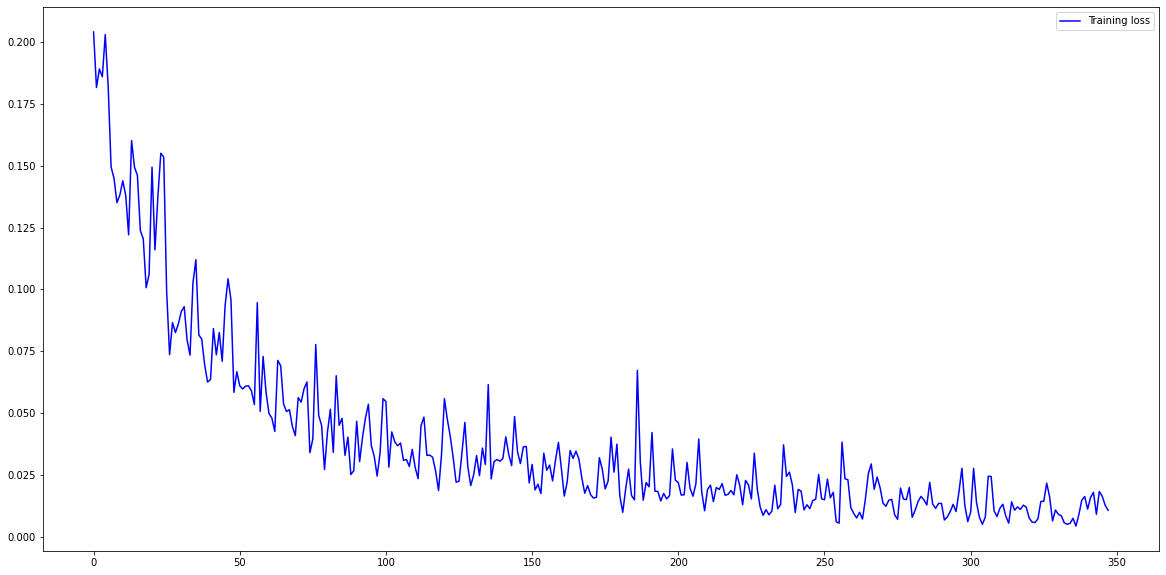

In [99]:
y=embedding_model.history.history["loss"]
x=np.arange(len(y))

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(x, y, 'b', label='Training loss')
plt.legend()

In [68]:
### fully paper based model architecture except for the last layer###

input_=Input((150,150,1))
conv1=Conv2D(64,(10,10),activation="relu")
maxp1=MaxPooling2D((2,2))
conv2=Conv2D(128,(7,7),activation="relu")
maxp2=MaxPooling2D((2,2))
conv3=Conv2D(128,(4,4),activation='relu')
maxp3=MaxPooling2D((2,2))
conv4=Conv2D(256,(4,4),activation='relu')
conv5=Conv2D(256,(1,1),activation="relu")
flatten_layer=Flatten()
dense1= Dense(128,activation='relu')
dr1=layers.Dropout(0.2)
dense2=Dense(256,activation="relu")
dr2=layers.Dropout(0.2)
dense3=Dense(128,activation="sigmoid")
dist=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
embedding_model_1=tf.keras.Sequential([input_,conv1,maxp1,conv2,maxp2,conv3,maxp3,conv4,flatten_layer,dense1,dr1,dense2,dr2,dense3,dist])
embedding_model_1.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 141, 141, 64)      6464      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 70, 70, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 64, 64, 128)       401536    
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 29, 29, 128)       262272    
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 11, 11, 256)     

In [69]:
embedding_model_1.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())
model_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='.\\tmp\\paper_siam_ckpt_{epoch:04d}_{loss:.5f}.hdf5',
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True)

history_1 = embedding_model_1.fit(train_fin, epochs=100,callbacks=[model_checkpoint_1])

Epoch 1/100
215/215 [==============================] - 29s 114ms/step - loss: 0.9878
Epoch 2/100
215/215 [==============================] - 28s 114ms/step - loss: 0.9836
Epoch 3/100
215/215 [==============================] - 28s 115ms/step - loss: 0.9845
Epoch 4/100


KeyboardInterrupt: 

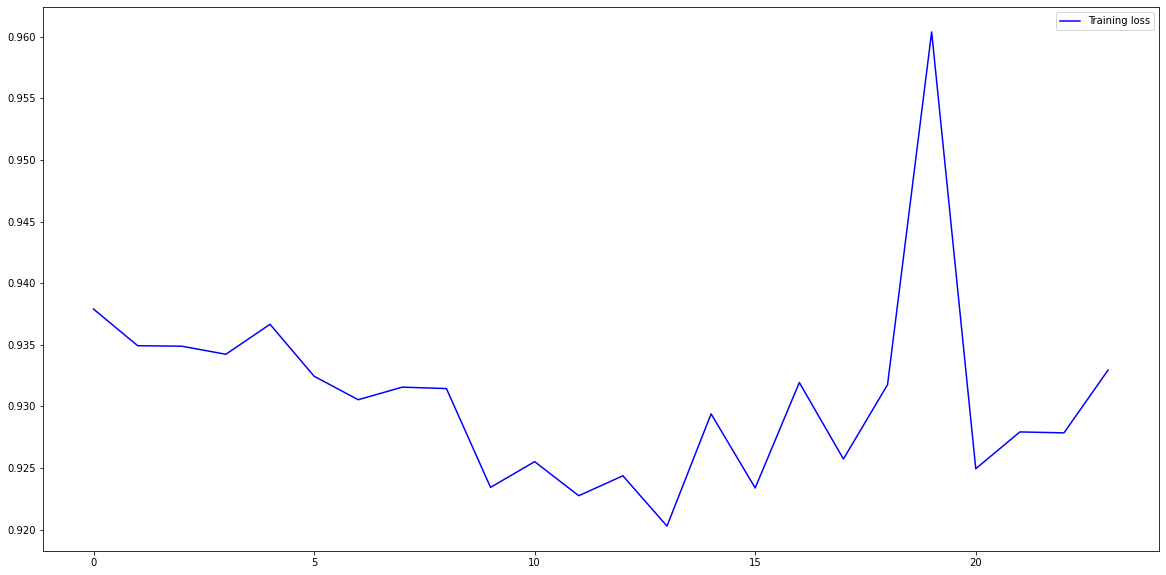

In [16]:
y=embedding_model_1.history.history["loss"]
x=np.arange(len(y))

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(x, y, 'b', label='Training loss')
plt.legend()

In [73]:
##second trial on the siamese model##

base_resnet=tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(150,150,),classes=3)
# for i in base_resnet.layers[:(math.ceil(len(base_resnet.layers)/2))]:
#     i.trainable=False
conv1=Conv2D(10,(2,2),activation="relu")
maxp1=MaxPooling2D((2,2))
flatten_layer = Flatten()
dist=tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
embedding_model_2=tf.keras.Sequential([base_resnet,conv1,maxp1,flatten_layer,dense1,dr1,dist])
embedding_model_2.summary()

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [53]:
embedding_model_2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())


In [55]:
model_checkpoint_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='.\\tmp\\paper_siam2_ckpt_{epoch:04d}_{loss:.5f}.hdf5',
    save_weights_only=True,
    monitor='loss',
    mode='auto',
    save_best_only=True)
history_2 = embedding_model_2.fit(train_fin, epochs=100,callbacks=[model_checkpoint_2])

Epoch 1/100
     10/Unknown - 10s 274ms/step - loss: 0.8169

ResourceExhaustedError:  OOM when allocating tensor with shape[30,512,5,5] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_24/resnet50/conv5_block3_3_conv/Conv2D/Conv2DBackpropInput (defined at \AppData\Local\Temp/ipykernel_9380/17102663.py:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_109972]

Function call stack:
train_function


# Saving Model and Weights

In [107]:

from keras.models import model_from_json
os.makedirs(".\\tmp\\3_cat_model")
# serialize model to JSON
model_json = embedding_model.to_json()
with open(".\\tmp\\3_cat_model\\emb_model_3cat.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
embedding_model.save_weights(".\\tmp\\emb_model_3cat.h5") #checkpoints in tmp file can also be used to load weights

# Data For Testing and Visualizing vector distances of each class in model

In [106]:
x_test,y_test=next(iter(test_ds))

results=embedding_model.predict(x_test)

vec_path=".\\tmp\\test_results\\vecs.tsv"
meta_path=".\\tmp\\test_results\\meta.tsv"
np.savetxt(vec_path, results, delimiter='\t')
out_m=io.open(meta_path,"w",encoding="utf-8")
for img,labels in list(zip(x_test.numpy(),y_test.numpy())):
    out_m.write(str(labels) + "\n")
out_m.close()
    
    

(150, 108)

# Loading Embedding Model for Vector Building

In [16]:
pwd

'G:\\TFODCourse_SUB'

In [40]:
import math
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import Dense, Conv2D, Flatten 
from tensorflow.keras import Model
from tensorflow.keras import layers


base_resnet=tf.keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(150,150,3),classes=len(label_map))
# for i in base_resnet.layers[:(math.ceil(len(base_resnet.layers)/2))]:
#     i.trainable=False
conv1=Conv2D(48,(1,1),padding="valid",activation="relu")
dr1=layers.Dropout(0.3)
avgpool1 = tf.keras.layers.AveragePooling2D(pool_size=(2, 2))
conv2=Conv2D(78,(1,1),padding="same",activation="relu")
dr2=layers.Dropout(0.2)
flatten_layer = Flatten()
dense1 = Dense(108,activation='sigmoid')
embedding_model=tf.keras.Sequential([base_resnet,conv1,avgpool1,conv2,flatten_layer,dense1])
embedding_model.load_weights(r"G:\TFODCourse_SUB\tmp\3cat_ckpt_0337_0.00427.hdf5")
embedding_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 conv2d_6 (Conv2D)           (None, 5, 5, 48)          98352     
                                                                 
 average_pooling2d_3 (Averag  (None, 2, 2, 48)         0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 78)          3822      
                                                                 
 flatten_3 (Flatten)         (None, 312)               0         
                                                                 
 dense_8 (Dense)             (None, 108)               33804     
                                                      

In [7]:
embedding_model.load_weights(r"C:\Users\User\Downloads\inhouse4cat_v2_ckpt_0097_0.04463.hdf5")

# Freezing Embedding Layers for backbone usage and adding classification layers

In [41]:
embedding_model.trainable=False
dense2 = Dense(3,activation='softmax')
class_model=tf.keras.Sequential([embedding_model,dense2])
class_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 108)               23723690  
                                                                 
 dense_9 (Dense)             (None, 3)                 327       
                                                                 
Total params: 23,724,017
Trainable params: 327
Non-trainable params: 23,723,690
_________________________________________________________________


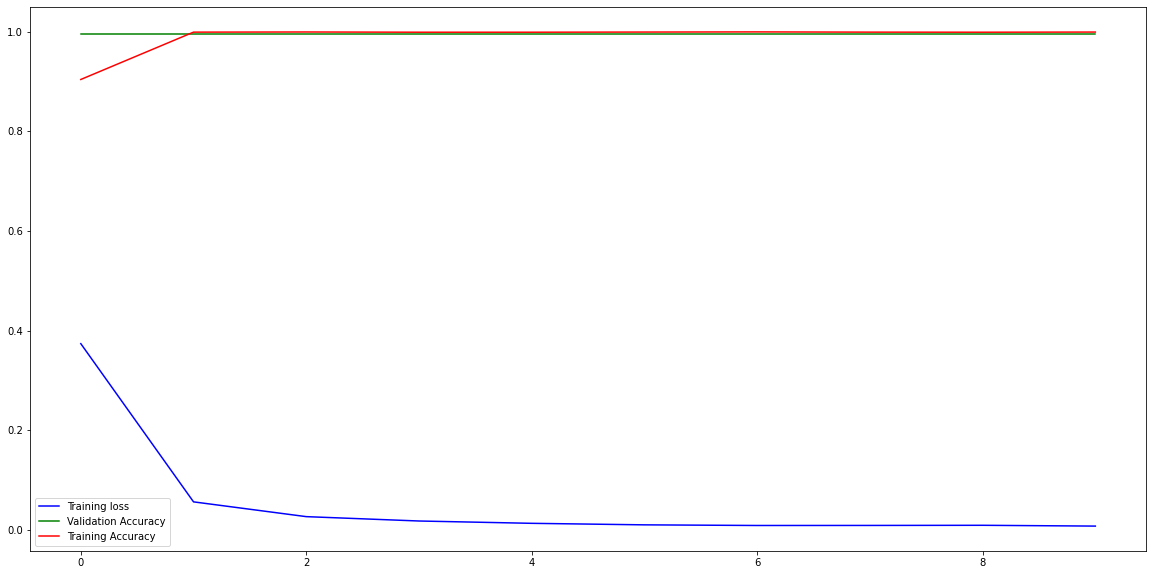

In [49]:
y_valacc=class_model.history.history["val_accuracy"]
y_acc=class_model.history.history["accuracy"]
y_loss=class_model.history.history["loss"]
x=np.arange(len(y_valacc))

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(x, y_loss, 'b', label='Training loss')
plt.plot(x, y_valacc, 'g', label='Validation Accuracy')
plt.plot(x, y_acc, 'r', label='Training Accuracy')
plt.legend()

In [53]:
from keras.models import model_from_json
# os.makedirs("G:\\TFODCourse_SUB\\tmp\\3_cat_model")
# serialize model to JSON
model_json = class_model.to_json()
with open("G:\\TFODCourse_SUB\\tmp\\3_cat_model\\class_model_3cat_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
class_model.save_weights("G:\\TFODCourse_SUB\\tmp\\class_model_3cat_2.h5") #checkpoints in tmp file can also be used to load weights

C:\Users\User\anaconda3\envs\torchenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# Making the Embedding Vectors for Linear Dataset

In [75]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

from PIL import Image
#os.chdir(".\\data_1")
def create_emb_data(path,embedding_model,label_map):
    paths= glob.glob(path+"\\*\\*.jpg")
    label_arr=[]
    emb_arr=np.array([])
    for path in paths:
        label= path.split("\\")[-2]
        label_idx=label_map[label]
        img=cv2.imread(path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        label_idx=label_map[path.split('\\')[-2]]
        print(label_idx,path.split('\\')[-2])
        im = Image.fromarray(img, 'RGB')
        #Resizing into dimensions you used
        im = im.resize((150,150))
        img_array = (np.array(im).astype(np.float32)/255)
        #Expand dimensions to match the 4 D Tensor shape.
        img_array = np.expand_dims(img_array, axis = 0)
        embedding=embedding_model.predict(img_array)
        embedding=embedding/np.linalg.norm(embedding, ord=2)
        embedding=np.ravel(embedding)
        emb_arr=np.concatenate((emb_arr,embedding), 0)
        label_arr.append(label_idx)
        print(path)
    return (emb_arr,np.array(label_arr))
    
paths=r'G:\TFODCourse_SUB\train'
xgb_train,ygb_train=create_emb_data(paths,embedding_model,label_map)

0 ep_black
G:\TFODCourse_SUB\train\ep_black\00107.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\00489.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\00605.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\0080b.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\00cb3.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\00e87.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\00efb.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\01015.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\01b53.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\01da5.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\01eda.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\020af.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\02aaa.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\02b54.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\02b88.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\03134.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\033d0.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\033f7.jpg
0 ep_black
G:\TFODCourse_SUB

0 ep_black
G:\TFODCourse_SUB\train\ep_black\1924e.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\19364.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\19669.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\198a6.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\198ec.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\19b42.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\19cbc.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\19cfb.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1a3c0.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1a4d0.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1a6b0.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1b34a.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1b39d.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1b47c.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1b9e9.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1bb60.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1bc13.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\1be13.jpg
0 ep_black
G:\TFODCourse_SUB

0 ep_black
G:\TFODCourse_SUB\train\ep_black\33175.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\33257.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\333fe.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\336a6.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\33761.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\338a2.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\3394a.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\33a50.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\33a54.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\33ac9.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\34723.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\348e4.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\34ac0.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\34b23.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\34b60.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\34b61.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\34d15.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\3521c.jpg
0 ep_black
G:\TFODCourse_SUB

0 ep_black
G:\TFODCourse_SUB\train\ep_black\4896c.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\48abb.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4983b.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\49904.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\499b3.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\49d56.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\49d5d.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4a082.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4a316.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4a698.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4a899.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4aa0e.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4ad0c.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4adca.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4b52b.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4b6a4.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4b746.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\4b7a8.jpg
0 ep_black
G:\TFODCourse_SUB

G:\TFODCourse_SUB\train\ep_black\64d12.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\64d73.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\64fd9.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\65806.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\6586c.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\6587e.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\65ac7.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\65b2c.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\65ef7.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\661d0.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\662da.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\66430.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\6658d.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\66618.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\66749.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\66777.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\66983.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\66990.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_b

G:\TFODCourse_SUB\train\ep_black\7bf1f.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7c1cf.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7c6b5.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7c811.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7c9a7.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7cba5.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7cd84.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7d07f.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7d0ed.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7d19e.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7d326.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7d553.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7d5b8.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7d5c7.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7dc3d.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7dda9.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7dedf.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\7e0eb.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_b

G:\TFODCourse_SUB\train\ep_black\94fbf.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\95194.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\953dc.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\95bb9.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\95f0f.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\963dc.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\9680b.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\969c8.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\969fb.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\96c23.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\96d93.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\96db2.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\97974.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\97bfb.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\97d8c.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\97df2.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\97f3a.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\97f4d.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_b

0 ep_black
G:\TFODCourse_SUB\train\ep_black\abd37.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\abe9f.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ac0b4.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ac18d.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ac20e.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ac51d.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ac992.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\acd8a.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\acf31.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ad3a2.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ad46c.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ad5fd.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ad80f.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\ad814.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\adaed.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\add33.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\adf4b.jpg
0 ep_black
G:\TFODCourse_SUB\train\ep_black\adfd4.jpg
0 ep_black
G:\TFODCourse_SUB

KeyboardInterrupt: 

In [13]:
label_map

{'ep_black': 0, 'ep_green': 1, 'ep_orange': 2}

In [21]:
xgb_train=xgb_train.reshape(-1,108)

In [23]:
xgb_train.shape

(4605, 108)

In [29]:
pwd

'G:\\TFODCourse_SUB\\train'

In [34]:
data=np.hstack([xgb_train,ygb_train.reshape(-1,1).astype('int32')])

In [35]:
from numpy import savetxt
savetxt('.\\xgb_data.csv', data, delimiter=',')

In [36]:
import pandas as pd
df=pd.read_csv('.\\xgb_data.csv',names=["x_"+str(i) if i<108 else "y_1" for i in range(109)])

In [37]:
df.

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_99,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,y_1
0,0.0,0.0,0.277350,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.277350,0.277350,0.0,0.277350,0.0,0.0,0.0,0.0
1,0.0,0.0,0.277350,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.277350,0.277350,0.0,0.277350,0.0,0.0,0.0,0.0
2,0.0,0.0,0.277350,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.277350,0.277350,0.0,0.277350,0.0,0.0,0.0,0.0
3,0.0,0.0,0.277350,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.277350,0.277350,0.0,0.277350,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4600,0.0,0.0,0.277350,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.277350,0.277350,0.0,0.277350,0.0,0.0,0.0,2.0
4601,0.0,0.0,0.267261,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.267261,0.267261,0.0,0.267261,0.0,0.0,0.0,2.0
4602,0.0,0.0,0.277350,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.277350,0.277350,0.0,0.277350,0.0,0.0,0.0,2.0
4603,0.0,0.0,0.277350,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.277350,0.277350,0.0,0.277350,0.0,0.0,0.0,2.0


In [146]:
from pycaret.classification import *
model=setup(data=df,target="y_1")
model=compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.8487,0.0000,0.8401,0.8546,0.8474,0.7708,0.7745,0.0300
ridge,Ridge Classifier,0.8433,0.0000,0.8357,0.8471,0.8422,0.7630,0.7657,0.0050
knn,K Neighbors Classifier,0.8352,0.9312,0.8305,0.8409,0.8353,0.7517,0.7542,0.0530
rf,Random Forest Classifier,0.8351,0.9461,0.8306,0.8444,0.8349,0.7512,0.7558,0.1910
lightgbm,Light Gradient Boosting Machine,0.8324,0.9402,0.8254,0.8388,0.8321,0.7470,0.7503,0.7470
lr,Logistic Regression,0.8310,0.9474,0.8222,0.8368,0.8293,0.7443,0.7483,0.5950
lda,Linear Discriminant Analysis,0.8310,0.8941,0.8224,0.8376,0.8298,0.7441,0.7480,0.0100
et,Extra Trees Classifier,0.8310,0.9424,0.8247,0.8379,0.8302,0.7445,0.7483,0.1790
nb,Naive Bayes,0.8296,0.9173,0.8229,0.8355,0.8292,0.7427,0.7457,0.0060
gbc,Gradient Boosting Classifier,0.8282,0.9403,0.8222,0.8336,0.8281,0.7408,0.7434,0.4560


In [55]:
x_train,y_train=df.iloc[:,:-1],df.iloc[:,-1]

In [49]:
from sklearn import svm

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from time import time
print("Fitting the classifier to the training set")
x_train,y_train=np.array(df.iloc[:,:-1]),np.array(df.iloc[:,-1])

t0 = time()
param_grid = {
    "C": [1e3, 5e3, 1e4, 5e4, 1e5,1e10],
    "gamma": [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}
clf = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)
clf = clf.fit(x_train, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 26.530s
Best estimator found by grid search:
SVC(C=5000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


In [94]:
svm_final=svm.SVC(C=5000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [95]:
svm_final.fit(x_train,y_train)

SVC(C=5000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.005,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [96]:
svm_final.predict(np.array(df.iloc[4,:-1]).reshape(1,-1))

array([0.])

In [ ]:
import pickle
filename = '.\\tmp\\svm\\svm_test.sav'
pickle.dump(model, open(filename, 'wb'))

In [99]:
loaded_model = pickle.load(open('.\\tmp\\svm\\svm_test.sav', 'rb'))

In [115]:
loaded_model.predict(np.array(df.iloc[285,:-1]).reshape(1,-1))

array([0.])

In [150]:
df.head(10)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,x_99,x_100,x_101,x_102,x_103,x_104,x_105,x_106,x_107,y_1
0,1.345043e-17,6.825400e-26,2.798376e-02,0.000512,2.018111e-01,4.150980e-33,0.001389,2.005740e-01,4.195926e-09,4.940881e-16,...,4.532121e-09,2.018111e-01,9.460072e-12,4.815310e-12,0.000000,1.680677e-25,1.737435e-28,6.370274e-20,2.018111e-01,0.0
1,9.714648e-03,1.348192e-03,7.680752e-04,0.229924,4.176890e-03,1.822357e-08,0.201014,2.798079e-02,2.718927e-01,1.529761e-01,...,3.841864e-02,8.254879e-05,2.616898e-01,2.696404e-01,0.000037,2.569299e-06,3.253818e-05,1.509850e-06,2.068578e-03,0.0
2,1.321989e-02,7.188205e-04,3.656897e-05,0.203192,3.209141e-04,4.532803e-05,0.208307,1.709719e-04,2.075141e-01,2.071616e-02,...,2.074503e-01,2.928908e-05,2.075139e-01,2.055077e-01,0.000193,1.089566e-03,5.490623e-03,1.255364e-04,1.853212e-01,0.0
3,0.000000e+00,0.000000e+00,3.851542e-18,0.221366,2.213655e-01,0.000000e+00,0.221366,4.705501e-21,9.445831e-03,0.000000e+00,...,2.213656e-01,7.780826e-35,8.409239e-10,1.877813e-03,0.000000,0.000000e+00,0.000000e+00,8.624646e-07,2.213656e-01,0.0
4,0.000000e+00,0.000000e+00,1.825742e-01,0.000000,1.825742e-01,0.000000e+00,0.000000,1.825742e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,1.825742e-01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.825742e-01,0.0
5,0.000000e+00,0.000000e+00,1.825742e-01,0.000000,1.825742e-01,0.000000e+00,0.000000,1.825742e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,1.825742e-01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.825742e-01,0.0
6,2.336439e-11,2.331950e-08,1.416638e-19,0.207548,1.057648e-16,2.207020e-07,0.210504,6.632759e-21,2.104841e-01,4.065666e-02,...,2.104859e-01,3.685487e-18,2.105011e-01,2.105046e-01,0.000004,1.063531e-08,1.228246e-05,1.043507e-03,4.060748e-09,0.0
7,3.924011e-02,3.396969e-03,2.436854e-01,0.000545,2.373173e-01,6.480400e-03,0.018622,2.144272e-01,1.317102e-02,4.109677e-03,...,4.846205e-03,1.409172e-01,3.878799e-03,1.778354e-03,0.000514,1.018191e-02,9.515833e-03,9.726743e-03,1.867742e-01,0.0
8,0.000000e+00,0.000000e+00,0.000000e+00,0.200000,0.000000e+00,0.000000e+00,0.200000,0.000000e+00,2.000000e-01,0.000000e+00,...,2.000000e-01,0.000000e+00,2.000000e-01,2.000000e-01,0.000000,0.000000e+00,1.560100e-38,0.000000e+00,2.000000e-01,0.0
9,0.000000e+00,0.000000e+00,1.856953e-01,0.000000,1.856953e-01,0.000000e+00,0.000000,1.856953e-01,0.000000e+00,0.000000e+00,...,0.000000e+00,1.856953e-01,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.856953e-01,0.0


## Siamese Model Evaluation

In [41]:
from PIL import Image
import imutils
path="G:\\test_snn\\1639042231379_1.jpg"
img=cv2.imread(path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
im = Image.fromarray(img, 'RGB')
#Resizing into dimensions you used
im = im.resize((150,150))
img_array = (np.array(im).astype(np.float32)/255)
#Expand dimensions to match the 4 D Tensor shape.
img_array = np.expand_dims(img_array, axis = 0)
embedding=embedding_model.predict(img_array)
embedding=embedding/np.linalg.norm(embedding, ord=2)

In [42]:
def _normalize_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return img, label
res=[]
img=cv2.imread("G:\\test_snn\\1639042231360_1.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
im = Image.fromarray(img, 'RGB')
#Resizing into dimensions you used
im = im.resize((150,150))
img_array = (np.array(im).astype(np.float32)/255)
#Expand dimensions to match the 4 D Tensor shape.
img_array = np.expand_dims(img_array, axis = 0)
embedding1=embedding_model.predict(img_array)
embedding1=embedding1/np.linalg.norm(embedding1, ord=2)
d=tf.reduce_sum(np.square(embedding-embedding1),-1)
res.append(d)

In [43]:
res[0].numpy()

array([9.077049e-16], dtype=float32)

In [84]:
tf.reduce_sum(np.square(embedding-embedding1),-1)

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.], dtype=float32)>

In [88]:
total_mistakes=(np.array(res)<1).sum()

In [93]:
(np.array(res)<1).shape

(1464, 1)

In [103]:
np.array(paths).reshape(-1,1)[np.array(res)<1]

array(['G:\\TFODCourse_SUB\\train\\ep_green\\1f93c.jpg',
       'G:\\TFODCourse_SUB\\train\\ep_green\\ffbd7.jpg'], dtype='<U42')

In [104]:
class_model_1=

array([0.        , 0.38095236], dtype=float32)

In [88]:
from PIL import Image
path="G:\\TFODCourse_SUB\\train\\ep_black\\0c911.jpg"
img=cv2.imread(path)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
label_idx=label_map[path.split('\\')[-2]]
im = Image.fromarray(img, 'RGB')
#Resizing into dimensions you used
im = im.resize((150,150))
img_array = (np.array(im).astype(np.float32)/255)
#Expand dimensions to match the 4 D Tensor shape.
img_array = np.expand_dims(img_array, axis = 0)
idx_=class_model.predict(img_array)
list(label_map.keys())[np.argmax(idx_)]

'ep_black'

In [63]:
pwd

'G:\\TFODCourse_SUB'

In [78]:
class_model.save("imageacc_model")

INFO:tensorflow:Assets written to: imageacc_model\assets


C:\Users\User\anaconda3\envs\torchenv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\User\anaconda3\envs\torchenv\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [67]:
from tensorflow.keras.models import load_model
 
# load model
class_model1 = load_model('imageacc_model.h5')

'history' is not recognized as an internal or external command,
operable program or batch file.


## Convert TF Serving to CV2


In [79]:
net = cv2.dnn.readNetFromONNX("G:\\TFODCourse_SUB\\imageacc_model.onnx")

In [94]:
img_original=cv2.imread(r"G:\TFODCourse_SUB\train\ep_orange\0a04f.jpg")

In [95]:
img=cv2.cvtColor(img_original,cv2.COLOR_BGR2RGB)
label_idx=label_map[path.split('\\')[-2]]
im = Image.fromarray(img, 'RGB')
#Resizing into dimensions you used
im = im.resize((150,150))
img_array = (np.array(im).astype(np.float32)/255)
#Expand dimensions to match the 4 D Tensor shape.
img_array = np.expand_dims(img_array, axis = 0)
net.setInput(img_array)
Out=net.forward()

In [66]:
layerNames=net.getLayerNames()
outputNames=[layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]

# Documentation Plots

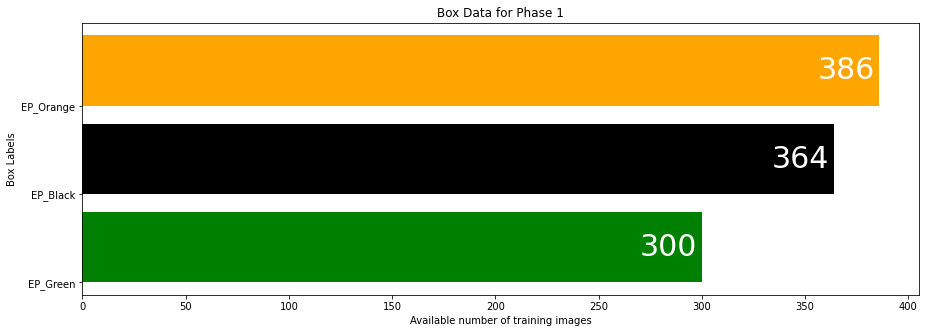

In [145]:
phase1_dict={"EP_Green":300,"EP_Black":364,"EP_Orange":386}
courses = list(phase1_dict.keys())
values = list(phase1_dict.values())

fig, ax = plt.subplots(figsize = (15, 5))    
width = 0.75 # the width of the bars 
ind = np.arange(len(values))  # the x locations for the groups
ax.barh(courses, values, color =["green","black","orange"], align='edge') 
# creating the bar plot
labels=["300","364","386"]
for bar,label,value in zip(ax.patches, labels,values):
    ax.text(value-30, bar.get_y()+bar.get_height()/2, label, color = 'white', ha = 'left', va = 'center',fontsize=30) 


plt.xlabel("Available number of training images")
plt.ylabel("Box Labels")
plt.title("Box Data for Phase 1")
plt.show()

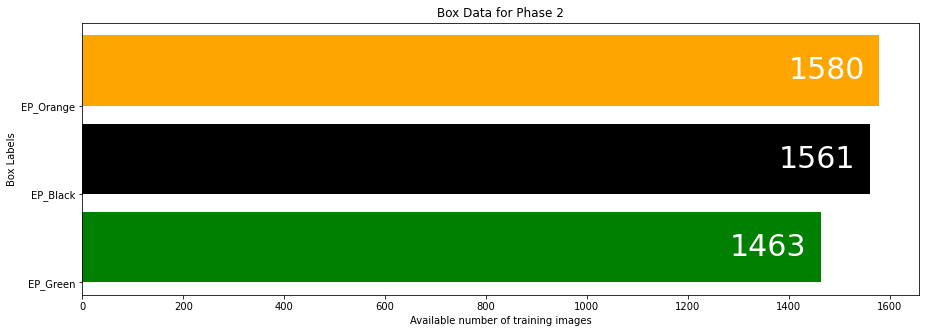

In [153]:
phase2_dict={"EP_Green":1464,"EP_Black":1561,"EP_Orange":1580}
courses = list(phase2_dict.keys())
values = list(phase2_dict.values())

fig, ax = plt.subplots(figsize = (15, 5))    
width = 0.75 # the width of the bars 
ind = np.arange(len(values))  # the x locations for the groups
ax.barh(courses, values, color =["green","black","orange"], align='edge') 
# creating the bar plot
labels=["1463","1561","1580"]
for bar,label,value in zip(ax.patches, labels,values):
    ax.text(value-180, bar.get_y()+bar.get_height()/2, label, color = 'white', ha = 'left', va = 'center',fontsize=30) 


plt.xlabel("Available number of training images")
plt.ylabel("Box Labels")
plt.title("Box Data for Phase 2")
plt.show()